In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from atusfunclib import load_data
from activitylib import ACTINFO
import wlmetrics as wlm
import pickle
from datetime import date
from scipy.stats import gaussian_kde

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn import metrics
from sklearn.externals import joblib
from sklearn import base

In [5]:
from modellib import compute_mse, BaseResEnsembleEstimator, DataFrameSelector, EstimatorTransformer, ImputeNumber

In [6]:
# Import all csv data
data_import = load_data(loc="data", loc_clean="cleaned_data", loc_codes="code_tables")

In [7]:
# Unpack individual dataframes
df, dfactcodes, dfeducodes, dfinccodes, dfagecodes, \
dfempcodes, dfindcodes, dfraccodes, dfloccodes, dfwhocodes, \
dfdemocodes = data_import

In [8]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [9]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [10]:
# Split by weekday and weekend/holiday
df_wehol = df[(df['TRHOLIDAY'] == 1) | (df['TRWEEKEND'] == 1)]
df_weday = df[(df['TRHOLIDAY'] == 0) & (df['TRWEEKEND'] == 0)]

In [11]:
del df

In [12]:
# Calculate metrics (i.e. y data)
df_weday_y = pd.DataFrame()
df_wehol_y = pd.DataFrame()

# Weekday
df_weday_y['metric5'] = wlm.w_l_balance_workday(df_weday, workid='0501', hours=9)
df_weday_y['metric6'] = wlm.w_l_balance_housework(df_weday, hours=4)

# Weekend/holiday
df_wehol_y['metric5'] = wlm.w_l_balance_workday(df_wehol, workid='0501', hours=9)
df_wehol_y['metric6'] = wlm.w_l_balance_housework(df_wehol, hours=4)

In [13]:
df_weday_y.head()

,metric5,metric6
0,False,False
3,False,True
4,False,False
5,False,True
6,False,False


In [14]:
df_wehol_y.head()

,metric5,metric6
1,False,False
2,False,True
8,False,True
10,True,False
11,False,False


In [15]:
# Features list
features = ['TEAGE', 'TESEX', 'GEMETSTA',
            'GESTFIPS', 'LATITUDE', 'LONGITUDE',
            'TELFS', 'TRDPFTPT',
            'TRSPPRES', 'TESPEMPNOT',
            'TESCHENR', 'PEEDUCA',
            'PTDTRACE',
            'TRCHILDNUM', 'TRNUMHOU',
            'TRDTOCC1', 'TEIO1COW', 'TRERNWA']

catfeatures = ['GEMETSTA', 'GESTFIPS',
               'TELFS', 'TRDPFTPT',
               'TRSPPRES', 'TESPEMPNOT',
               'TESCHENR',
               'PTDTRACE',
               'TRDTOCC1', 'TEIO1COW']

In [16]:
# Features matrix (i.e. X data)
df_weday_X = df_weday[features]
df_wehol_X = df_wehol[features]

In [17]:
# Split train-test indices
rs = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

train_wd, test_wd = rs.split(df_weday).next()
train_wh, test_wh = rs.split(df_wehol).next()

In [18]:
del df_weday
del df_wehol

## Set training and test data

In [395]:
m = 'metric6'
dt = 'weday'

if dt == 'weday':
    y = df_weday_y[m].iloc[train_wd].as_matrix()
    X = df_weday_X.iloc[train_wd]

    y_test = df_weday_y[m].iloc[test_wd].as_matrix()
    X_test = df_weday_X.iloc[test_wd]
else:
    y = df_wehol_y[m].iloc[train_wd].as_matrix()
    X = df_wehol_X.iloc[train_wd]

    y_test = df_wehol_y[m].iloc[test_wd].as_matrix()
    X_test = df_wehol_X.iloc[test_wd]

In [396]:
# Check fraction of False since classes are unbalanced (need to predict better than this)
print "{:.4f}".format(1.0 - y.sum() / float(y.shape[0]))

0.8444


## Combined model that uses both continuous and categorical models

In [431]:
# Polynominal features for age
agetrans = Pipeline([
    ('featse0', DataFrameSelector(feature_names=['TEAGE'], dtype=float)),
    ('scaler0', StandardScaler()),
    ('polyno0', PolynomialFeatures(degree=3, include_bias=True)),
])

# Location features
loctrans = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['LONGITUDE', 'LATITUDE'], dtype=float)),
    ('impute1', Imputer(missing_values='NaN', strategy='median', axis=0)),
])

# Education level feature
edutrans = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['PEEDUCA'], dtype=float)),
    ('impute2', Imputer(missing_values='NaN', strategy='median', axis=0)),
    ('scaler2', StandardScaler()),
    ('polyno2', PolynomialFeatures(degree=2, include_bias=False)),
])

# Weekly earnings feature
weatrans = Pipeline([
    ('featse3', DataFrameSelector(feature_names=['TRERNWA'], dtype=float)),
    ('impute3', ImputeNumber()),
    ('scaler3', StandardScaler()),
    ('polyno3', PolynomialFeatures(degree=2, include_bias=False)),
])

# Number of children/household features
lintrans = Pipeline([
    ('featse4', DataFrameSelector(feature_names=['TRCHILDNUM', 'TRNUMHOU'], dtype=float)),
    ('impute4', ImputeNumber()),
])

# Use label encoding (to prevent large feature spaces)
catlarge = Pipeline([
    ('featse1', DataFrameSelector(feature_names=['PTDTRACE',
                                                 'TRDTOCC1'], dtype=np.float64, ntn=True)),
])

# Use one-hot-encoding followed by truncated SVD to reduce feature count
catsmall = Pipeline([
    ('featse2', DataFrameSelector(feature_names=['GEMETSTA',
                                                 'TELFS',
                                                 'TRDPFTPT',
                                                 'TRSPPRES',
                                                 'TESCHENR',
                                                 'TEIO1COW'], dtype=np.int64, ntn=True)),
    ('oencode', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

est_full = Pipeline([
    ('union01', FeatureUnion([
        ('catl', catlarge),
        ('cats', catsmall),
        ('agetran', agetrans),
        ('loctran', loctrans),
        ('edutran', edutrans),
        ('weatran', weatrans),
        ('lintran', lintrans)
    ])),
    ('scaler', StandardScaler()),
    ('rfclass', RandomForestClassifier(n_estimators=20, max_depth=14, random_state=42))
])

In [432]:
# Grid search CV
tmd = [8, 10, 12, 14, 16, 18, 20, 22, 24, 28, 30, 32]
gridsearch_full = GridSearchCV(est_full,
                              {'rfclass__max_depth': tmd,
                              },
                              cv=3,
                              n_jobs=-2,
                              scoring='f1',
                              verbose=True)

In [433]:
gridsearch_full.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed:   13.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('catl', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.float64'>,
         feature_names=['PTDTRACE', 'TRDTOCC1'], ntn=True))])), ('cats', Pipeline(memory=None,
     steps=[('featse2', DataFrameSe...stimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'rfclass__max_depth': [8, 10, 12, 14, 16, 18, 20, 22, 24, 28, 30, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=True)

In [434]:
gridsearch_full.best_params_

{'rfclass__max_depth': 14}

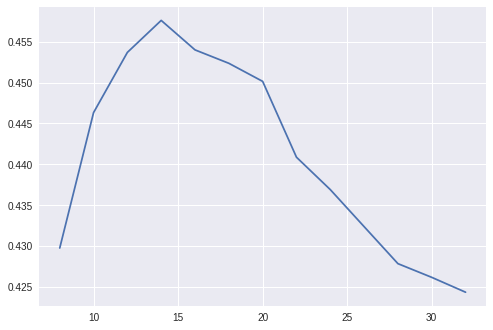

In [435]:
plt.plot(tmd, gridsearch_full.cv_results_['mean_test_score'])

### Fitting using the best parameters on training set for a specific metric

In [436]:
est_full.fit(X, y)

Pipeline(memory=None,
     steps=[('union01', FeatureUnion(n_jobs=1,
       transformer_list=[('catl', Pipeline(memory=None,
     steps=[('featse1', DataFrameSelector(dtype=<type 'numpy.float64'>,
         feature_names=['PTDTRACE', 'TRDTOCC1'], ntn=True))])), ('cats', Pipeline(memory=None,
     steps=[('featse2', DataFrameSe...stimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [437]:
est_full.score(X, y)

0.90250551905737164

In [438]:
metrics.accuracy_score(y_test, est_full.predict(X_test))

0.87887492519449428

In [439]:
# Pickle model
joblib.dump(est_full, 'models/pred_model_atus_CLASS_FULLEST_{}_{}_{}.pkl'.format(dt, m, date.today()))

['models/pred_model_atus_CLASS_FULLEST_weday_metric6_2017-11-07.pkl']